# Recommendation Systems for Amazon Beauty Products

## Overview

For the purpose of this project, we are a team of internal data scientists at Amazon. This project aims to create a recommendation system for the Amazon marketing team to utilize to send targeted recommendation e-mails to users who have purchased and rated products within 30 days. A collaborative approach was taken, meaning recommendations will be made by comparing similar reviewer profiles based on existing ratings. 

## Business Problem

Amazon's marketing team for beauty products has recognized a big opportunity to improve the emails they send to customers following a purchase. Customers open these post-purchase emails 17% more often than other types of automated emails. In addition to the visibility of post-purchase emails, their timing is critically important in the lifecyle of a customer. Succesfully re-engaging a customer at the post-purchase stage places them back into a consideration stage which will eventually lead to future purchases, increasing the customer's purchase frequency and lifetime value. However, re-engagment depends on these emails featuring content that customers want to engage with.

To help improve the engagment with their post-purchase emails, Amazon's beauty marketing team has pulled in an internal group of data scientists to create a recommendation system that will select personalized product recommendations for customers to include in post-purchase emails. Succesfull product recommendations must be personalized, relevant, and timely. Personalized in that they accurately predict products a given customer will enjoy, relevant because they don't recommend products the customer just purchased, and timely becuase they have the ability to tailor recommendations to seasonal events.

## Data Understanding and Preparation

Data for this project was pulled from a compiled dataset of Amazon Beauty product reviews and meta data in two seperate JSON files. The datasets can be found here (LINK TO SITE). We utlized the smaller dataset known as 5-core which contained data for products and reviewers with at least 5 entries.

Our review data contained 198,502 reviews from 22,363 reviewers. The reviews spanned across 12,101 unique products. Reviews ranged on a scale of 1-5. A majority of reviews received an overall review of 5, which could be a limitation to our model.

Our data did not require much cleaning. We selected the appropriate columns of our model to utilize for surprise, which included 'reviewerID', 'asin', and 'overall'. This data contained our unique reviewer ID, unique product ID, and overall rating on a scale of 1-5.

In [1]:
#importing necessary libraries

import pandas as pd
import pickle
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from IPython.core.display import HTML

%matplotlib inline

In [2]:
df = pd.read_json("reviews_Beauty_5.json",lines=True)
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013"
...,...,...,...,...,...,...,...,...,...
198497,A2BLFCOPSMBOZ9,B00LLPT4HI,Dave Edmiston,"[0, 0]",Just a little dab of this shea butter should b...,5,A little dab...,1405468800,"07 16, 2014"
198498,A1UQBFCERIP7VJ,B00LLPT4HI,Margaret Picky,"[0, 0]",This shea butter is completely raw and unrefin...,5,Pure organic raw shea butter,1405296000,"07 14, 2014"
198499,A35Q0RBM3YNQNF,B00LLPT4HI,M. Hill,"[0, 0]",The skin is the body's largest organ and it ab...,5,One Pound Organic Grade A Unrefined Shea Butter,1405468800,"07 16, 2014"
198500,A3LGT6UZL99IW1,B00LLPT4HI,"Richard C. Drew ""Anaal Nathra/Uthe vas Bethod...","[0, 0]",I have very dry elbows and knees. I have a to...,5,This stuff is amazing!,1405382400,"07 15, 2014"


In [3]:
#checking for nulls
df.isna().sum()

reviewerID           0
asin                 0
reviewerName      1386
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [4]:
#1386 reviewerNames left blank; we will not need reviewerName since utilizing reviewerID
#checking that all needed information is provided when reviewerName is NaN

In [5]:

df[df['reviewerName'].isnull()]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
8,A3LMILRM9OC3SA,9759091062,NaN,"[0, 0]",Did nothing for me. Stings when I put it on. I...,2,"no Lightening, no Brightening,......NOTHING",1405209600,"07 13, 2014"
1790,AK1H26O8DLMNN,B0000535UM,NaN,"[0, 0]",The first thickening shampoo that works on my ...,5,Actually works,1405123200,"07 12, 2014"
2242,APTLHR9PHGPXN,B00005NAOD,NaN,"[0, 0]","Kind of drying, not moisturizing. Kind of disa...",2,Inexpensive and feels that wY,1405209600,"07 13, 2014"
2304,AQWX644AFUFFK,B00005NFBD,NaN,"[0, 0]","This is just ok. For one, I found this in a st...",3,"Ok, nothing amazing",1405468800,"07 16, 2014"
3651,A43K5ZRQ87TO6,B00008PC1O,NaN,"[0, 0]",Works well and easy to use!,5,Five Stars,1405296000,"07 14, 2014"
...,...,...,...,...,...,...,...,...,...
197192,A1Z3AV93ONK5VF,B00KAL5JAU,NaN,"[0, 0]",We already had the Dead Sea Shampoo by Adovia ...,5,"Non greasy, silky shiny hair",1401235200,"05 28, 2014"
197193,A184I8GT3BHZQV,B00KAL5JAU,NaN,"[0, 1]",&#60;a href=&#34;http://www.tomoson.com/?code=...,5,Dead Sea Salt hair conditioner,1403568000,"06 24, 2014"
197194,A8C9EJORQD23,B00KAL5JAU,NaN,"[0, 1]",I use this with the Adovia shampoo I mention a...,5,Adovia does natural right!,1402272000,"06 9, 2014"
198446,A2PIGZCDGM4NJ7,B00L5JHZJO,NaN,"[10, 11]","This is a horrible product, most of the review...",1,Bad Product,1404864000,"07 9, 2014"


In [6]:
#checking that all reviewers have completed at least 5 reviews

In [7]:
df.reviewerID.value_counts()

reviewerID
A2V5R832QCSOMX    204
ALNFHVS3SC4FV     192
AKMEY1BSHSDG7     182
A3KEZLJ59C1JVH    154
ALQGOMOY1F5X9     150
                 ... 
A2E1P9J6TTHLS6      5
A1F09METOUKOCH      5
AJDOMSU08A256       5
A5AXASLO6LDMH       5
A2CG5Y82ZZNY6W      5
Name: count, Length: 22363, dtype: int64

In [8]:
#YAY! all reviewerIDs have value of at least 5, total of 22,363 reviewers

In [9]:

#checking that all products have been reviewed at least 5 times

In [10]:

df.asin.value_counts()

asin
B004OHQR1Q    431
B0043OYFKU    403
B0069FDR96    391
B000ZMBSPE    389
B00150LT40    329
             ... 
B0084OCSAE      5
B0084SSLVK      5
B0084T82A4      5
B0013N896U      5
B001AJOEFM      5
Name: count, Length: 12101, dtype: int64

In [11]:
#YAY! all products have at least 5 reviews, total of 12,101 different products

In [12]:
#looking at ratings distribution

In [13]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [14]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.io import to_image
import plotly.io as pio
init_notebook_mode(connected=True)

# Replace the path below with the actual path to your Orca executable
orca_executable_path = r'C:\Users\Fidelis Wanalwenge\anaconda3\envs\learn-env\orca.cmd'

# Set the Orca executable path
pio.orca.config.executable = orca_executable_path
pio.orca.config.save()

data = df['overall'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} Reviews'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

 # Do this first so we don't create a file if image conversion fails
img_data = to_image(fig,
        format='png',
        width=800,
        height=500,
        scale=5)

fig.write_image("images/reviews_distribution.png", scale=5)

In [15]:
#we see a majority of our ratings are 5s, which could impact our system

In [16]:
#exploring number of ratings per product

In [17]:
data = df.groupby('asin')['overall'].count().clip(upper=50)

In [18]:
data

asin
7806397051     8
9759091062    11
9788072216     5
9790790961     6
9790794231     5
              ..
B00L5KTZ0K    15
B00L6Q3BH6     5
B00LCEROA2     9
B00LG63DOM    10
B00LLPT4HI     7
Name: overall, Length: 12101, dtype: int64

In [19]:
data = df.groupby('asin')['overall'].count()

In [20]:
data

asin
7806397051     8
9759091062    11
9788072216     5
9790790961     6
9790794231     5
              ..
B00L5KTZ0K    15
B00L6Q3BH6     5
B00LCEROA2     9
B00LG63DOM    10
B00LLPT4HI     7
Name: overall, Length: 12101, dtype: int64

In [21]:
# Number of reviews per product
data = df.groupby('asin')['overall'].count()

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Reviews Per Product',
                   xaxis = dict(title = 'Number of Reviews Per Product'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

 # Do this first so we don't create a file if image conversion fails
img_data = to_image(fig,
        format='png',
        width=800,
        height=500,
        scale=5)

fig.write_image("images/reviews_per_product.png", scale=5)

In [22]:
#We see a majority of our products have 10 or less ratings

In [23]:
#exploring ratings distribution by user

In [24]:
# Number of reviews per user
data = df.groupby('reviewerID')['overall'].count()

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Reviews Per User',
                   xaxis = dict(title = 'Reviews Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

 # Do this first so we don't create a file if image conversion fails
img_data = to_image(fig,
        format='png',
        width=800,
        height=500,
        scale=5)

fig.write_image("images/reviews_per_user.png", scale=5)

In [25]:
#we see most users rated under 10 products

In [26]:
lower_rating = df.overall.min()

In [27]:
upper_rating = df.overall.max()

In [28]:
#Confirming our review range is 1 to 5

In [29]:
print('Review range: {0} to {1}'.format(lower_rating, upper_rating))

Review range: 1 to 5


In [30]:
#Creating dataframe with appropriate columns to run through surprise

In [31]:
surprise_df = df[['reviewerID', 'asin', 'overall']]
surprise_df

,reviewerID,asin,overall
0,A1YJEY40YUW4SE,7806397051,1
1,A60XNB876KYML,7806397051,3
2,A3G6XNM240RMWA,7806397051,4
3,A1PQFP6SAJ6D80,7806397051,2
4,A38FVHZTNQ271F,7806397051,3
...,...,...,...
198497,A2BLFCOPSMBOZ9,B00LLPT4HI,5
198498,A1UQBFCERIP7VJ,B00LLPT4HI,5
198499,A35Q0RBM3YNQNF,B00LLPT4HI,5
198500,A3LGT6UZL99IW1,B00LLPT4HI,5


In [32]:
#Checking average rating user to see if there are users who rate everything 1 or 5
#avg_rating_user = df.groupby("reviewerID")[["overall", "reviewerID"]].mean().sort_values("overall")
#avg_rating_user

avg_rating_user = df.groupby('reviewerID')['overall'].mean().sort_values()
avg_rating_user

reviewerID
A1W522Z24EPBJB    1.0
A2DPSPXFJ507C0    1.0
A1GQLVT0SWAWU     1.0
A1KLA02LZXAT46    1.0
A2MHHSACEJANSX    1.0
                 ... 
A15QGN6UXJVW9G    5.0
ANOJX4RAUJ9HL     5.0
A2RJT3IE2T6KXJ    5.0
A1ORLBQV893JF0    5.0
A4UHZXSLMBWT2     5.0
Name: overall, Length: 22363, dtype: float64

In [33]:
#low_rating_user = avg_rating_user[avg_rating_user["overall"]==1.0]

low_rating_user = avg_rating_user[avg_rating_user == 1.0]
low_rating_user

reviewerID
A1W522Z24EPBJB    1.0
A2DPSPXFJ507C0    1.0
A1GQLVT0SWAWU     1.0
A1KLA02LZXAT46    1.0
A2MHHSACEJANSX    1.0
A2RJTIE73NPN3C    1.0
ASWIC85F71H4J     1.0
A2TBE0N8JN6H4K    1.0
A1GPPMHYM6SMEW    1.0
Name: overall, dtype: float64

In [34]:
#only 9 users have rated every product as 1

In [35]:
high_rating_user = avg_rating_user[avg_rating_user == 5.0]
high_rating_user

reviewerID
A2FINIRQNXOTI     5.0
ATWS89FH6Y6S4     5.0
A16Q479PYT0G6N    5.0
A3OKW5VRXZG3OQ    5.0
A3O9Q3154FPZLL    5.0
                 ... 
A15QGN6UXJVW9G    5.0
ANOJX4RAUJ9HL     5.0
A2RJT3IE2T6KXJ    5.0
A1ORLBQV893JF0    5.0
A4UHZXSLMBWT2     5.0
Name: overall, Length: 2822, dtype: float64

In [36]:
#2822 users have rated every product as 5
#we decide to keep these users in our final dataset but will not use them to test our model for recommendations


# Exploring Meta Data

In [37]:
#Import our meta data 
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [38]:
meta_data_df = getDF("meta_Beauty.json.gz")
meta_data_df


,asin,description,title,imUrl,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin suc...",Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...,http://ecx.images-amazon.com/images/I/41DecrGO...,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturize...",NaN,NaN,NaN
1,0558925278,Mineral Powder Brush--Apply powder or mineral ...,Eco Friendly Ecotools Quality Natural Bamboo C...,http://ecx.images-amazon.com/images/I/51L%2BzY...,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes ...",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha b...",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1...,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotio...",NaN,NaN,NaN
3,0737104473,Limited edition Hello Kitty Lipstick featuring...,Hello Kitty Lustre Lipstick (See sellers comme...,http://ecx.images-amazon.com/images/I/31u6Hrzk...,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN
4,0762451459,"The mermaid is an elusive (okay, mythical) cre...",Stephanie Johnson Mermaid Round Snap Mirror,http://ecx.images-amazon.com/images/I/41y2%2BF...,NaN,"[[Beauty, Tools & Accessories, Mirrors, Makeup...",19.98,NaN,NaN
...,...,...,...,...,...,...,...,...,...
259199,B00LP2YB8E,Color: White\nFullness72 inches\nCenter Gather...,2t 2t Edge Crystal Rhinestones Bridal Wedding ...,http://ecx.images-amazon.com/images/I/41E630m-...,NaN,"[[Beauty, Hair Care, Styling Tools, Styling Ac...",NaN,NaN,NaN
259200,B00LOS7MEE,"The secret to long lasting colors, healthy nai...",French Manicure Gel Nail Polish Set - &quot;Se...,http://ecx.images-amazon.com/images/I/41skHL1O...,{'Beauty': 108820},"[[Beauty, Makeup, Nails, Nail Polish]]",NaN,"{'also_viewed': ['B0057JCYYE', 'B00LMXHR1Y', '...",NaN
259201,B00LPVG6V0,ResQ Organics Face & Body Wash - With Aloe Ver...,ResQ Organics Face &amp; Body Wash - Aloe Vera...,http://ecx.images-amazon.com/images/I/31C1w4Ku...,NaN,"[[Beauty, Skin Care, Face, Creams & Moisturize...",NaN,NaN,NaN
259202,B00LTDUHJQ,Color: White\n2 Tier \nFullness 72 inches\nSew...,2 Tier Tulle Elbow Wedding Veil with Ribbon Ed...,http://ecx.images-amazon.com/images/I/51%2B%2B...,NaN,"[[Beauty, Hair Care, Styling Tools, Styling Ac...",NaN,NaN,NaN


In [39]:

meta_data_df.head(100)

,asin,description,title,imUrl,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin suc...",Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...,http://ecx.images-amazon.com/images/I/41DecrGO...,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturize...",NaN,NaN,NaN
1,0558925278,Mineral Powder Brush--Apply powder or mineral ...,Eco Friendly Ecotools Quality Natural Bamboo C...,http://ecx.images-amazon.com/images/I/51L%2BzY...,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes ...",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha b...",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1...,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotio...",NaN,NaN,NaN
3,0737104473,Limited edition Hello Kitty Lipstick featuring...,Hello Kitty Lustre Lipstick (See sellers comme...,http://ecx.images-amazon.com/images/I/31u6Hrzk...,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN
4,0762451459,"The mermaid is an elusive (okay, mythical) cre...",Stephanie Johnson Mermaid Round Snap Mirror,http://ecx.images-amazon.com/images/I/41y2%2BF...,NaN,"[[Beauty, Tools & Accessories, Mirrors, Makeup...",19.98,NaN,NaN
...,...,...,...,...,...,...,...,...,...
95,6041134473,Restore your skin's firmness and elasticity.\n...,Cellulite Massager Face Lift Face Massager 24k...,http://ecx.images-amazon.com/images/I/41Mv9hUf...,{'Beauty': 26646},"[[Beauty, Skin Care, Face]]",NaN,"{'also_bought': ['B00K7HKVQO', 'B00IODYRJ0', '...",NaN
96,6040652705,Cure time: 3 minutes. Performs with ease when ...,Atnails Nail Uv Gel - Extreme White - French M...,http://ecx.images-amazon.com/images/I/41EPV9ft...,{'Beauty': 554040},"[[Beauty, Makeup, Nails, Nail Polish]]",NaN,NaN,NaN
97,6041134511,Gold has magic energy of resisting oxidation.\...,24k Gold Vibrating Face Lifting Tightening T S...,http://ecx.images-amazon.com/images/I/511oshir...,{'Beauty': 397584},"[[Beauty, Skin Care, Sets & Kits]]",NaN,{'also_viewed': ['6041134473']},NaN
98,604113449X,The Extra 600 Titanium Micro Needles per rolle...,Derma Roller Titanium 1.0mm 600 Micro Needles ...,http://ecx.images-amazon.com/images/I/41kVoMvq...,{'Beauty': 80310},"[[Beauty, Skin Care, Face, Treatments & Masks]]",12.87,"{'also_bought': ['B008CEDY5O', 'B00C7DYBX0', '...",NaN


In [40]:
meta_data_df.isna().sum()

asin                0
description     24707
title             444
imUrl              88
salesRank        5188
categories          0
price           69274
related         51350
brand          131038
dtype: int64

In [41]:
#exploring NaN and deciding which data is helpful to return to our users for recommendations

In [42]:
meta_data_df.shape

(259204, 9)

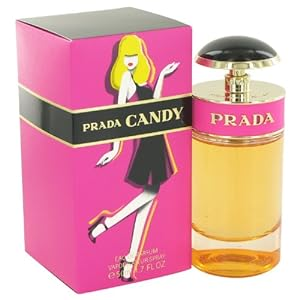

In [43]:
from IPython import display
display.Image(meta_data_df.loc[192]["imUrl"])
#display.Image(meta_data_df_cleaned.loc[259179]["imUrl"])

In [44]:
meta_data_df.price.describe()

count    189930.000000
mean         24.878165
std          33.431190
min           0.010000
25%           8.240000
50%          15.690000
75%          29.300000
max         999.990000
Name: price, dtype: float64

In [45]:
meta_data_df[meta_data_df['price'] == 999.99]

,asin,description,title,imUrl,salesRank,categories,price,related,brand
197364,B009PQIAL6,This beautifully sculpted and gracefully desig...,&quot;Vernet&quot; Black Dual Dryer Chair With...,http://ecx.images-amazon.com/images/I/41ks5sFA...,{'Beauty': 582815},"[[Beauty, Tools & Accessories, Nail Tools, Nai...",999.99,"{'also_viewed': ['B004O4N4OW', 'B009ZHVQYI', '...",NaN


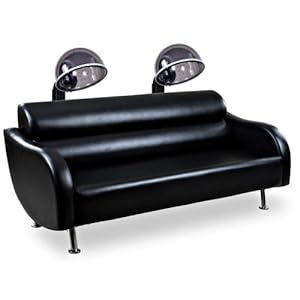

In [46]:
display.Image(meta_data_df.loc[197364]["imUrl"])

In [47]:
meta_data_df

,asin,description,title,imUrl,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin suc...",Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...,http://ecx.images-amazon.com/images/I/41DecrGO...,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturize...",NaN,NaN,NaN
1,0558925278,Mineral Powder Brush--Apply powder or mineral ...,Eco Friendly Ecotools Quality Natural Bamboo C...,http://ecx.images-amazon.com/images/I/51L%2BzY...,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes ...",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha b...",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1...,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotio...",NaN,NaN,NaN
3,0737104473,Limited edition Hello Kitty Lipstick featuring...,Hello Kitty Lustre Lipstick (See sellers comme...,http://ecx.images-amazon.com/images/I/31u6Hrzk...,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN
4,0762451459,"The mermaid is an elusive (okay, mythical) cre...",Stephanie Johnson Mermaid Round Snap Mirror,http://ecx.images-amazon.com/images/I/41y2%2BF...,NaN,"[[Beauty, Tools & Accessories, Mirrors, Makeup...",19.98,NaN,NaN
...,...,...,...,...,...,...,...,...,...
259199,B00LP2YB8E,Color: White\nFullness72 inches\nCenter Gather...,2t 2t Edge Crystal Rhinestones Bridal Wedding ...,http://ecx.images-amazon.com/images/I/41E630m-...,NaN,"[[Beauty, Hair Care, Styling Tools, Styling Ac...",NaN,NaN,NaN
259200,B00LOS7MEE,"The secret to long lasting colors, healthy nai...",French Manicure Gel Nail Polish Set - &quot;Se...,http://ecx.images-amazon.com/images/I/41skHL1O...,{'Beauty': 108820},"[[Beauty, Makeup, Nails, Nail Polish]]",NaN,"{'also_viewed': ['B0057JCYYE', 'B00LMXHR1Y', '...",NaN
259201,B00LPVG6V0,ResQ Organics Face & Body Wash - With Aloe Ver...,ResQ Organics Face &amp; Body Wash - Aloe Vera...,http://ecx.images-amazon.com/images/I/31C1w4Ku...,NaN,"[[Beauty, Skin Care, Face, Creams & Moisturize...",NaN,NaN,NaN
259202,B00LTDUHJQ,Color: White\n2 Tier \nFullness 72 inches\nSew...,2 Tier Tulle Elbow Wedding Veil with Ribbon Ed...,http://ecx.images-amazon.com/images/I/51%2B%2B...,NaN,"[[Beauty, Hair Care, Styling Tools, Styling Ac...",NaN,NaN,NaN


In [48]:
#renaming columns we plan to return to users for improved aesthetics

In [49]:
meta_data_df.rename(columns={'description':'Description', 'title': 'Product Name', 'asin':'ASIN', 'imUrl':'Image'}, inplace=True)

In [50]:
meta_data_df.head()

,ASIN,Description,Product Name,Image,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin suc...",Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...,http://ecx.images-amazon.com/images/I/41DecrGO...,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturize...",NaN,NaN,NaN
1,0558925278,Mineral Powder Brush--Apply powder or mineral ...,Eco Friendly Ecotools Quality Natural Bamboo C...,http://ecx.images-amazon.com/images/I/51L%2BzY...,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes ...",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha b...",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1...,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotio...",NaN,NaN,NaN
3,0737104473,Limited edition Hello Kitty Lipstick featuring...,Hello Kitty Lustre Lipstick (See sellers comme...,http://ecx.images-amazon.com/images/I/31u6Hrzk...,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN
4,0762451459,"The mermaid is an elusive (okay, mythical) cre...",Stephanie Johnson Mermaid Round Snap Mirror,http://ecx.images-amazon.com/images/I/41y2%2BF...,NaN,"[[Beauty, Tools & Accessories, Mirrors, Makeup...",19.98,NaN,NaN


In [51]:
meta_data_df.isna().sum()

ASIN                 0
Description      24707
Product Name       444
Image               88
salesRank         5188
categories           0
price            69274
related          51350
brand           131038
dtype: int64

In [52]:

#dropping brand due to large # of nulls

In [53]:
meta_data_df.drop(columns=['brand'], inplace=True)

# Methods

We utilized a Normal Predictor model for our initial model, which returned an RMSE of 1.5. We iterated through the following model algorithms to assess which models to further explore: SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), and CoClustering(). Our results were based on cross validation and returning the RMSE for each model, along with the fit time and test time. The top 3 models according to Test RMSE were SVDpp, SVD, and Baseline Only. Based on these results, we chose those 3 models to explore further.

We ran multiple grid searchs to test hyperparameters for SVDpp and SVD. Our best model based on RMSE was an SVD model with the following paramenters specified: (n_factors=2, n_epochs=20, biased=True).

# Setting Up Surprise

In [54]:
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(surprise_df, reader)

trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=23)

In [55]:
surprise_data

In [56]:
# How many users and items are in the trainset
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  22359 

Number of items:  12101 



In [57]:
print('Type trainset :',type(trainset),'\n')
print('Type testset :',type(testset))

Type trainset : <class 'surprise.trainset.Trainset'> 

Type testset : <class 'list'>


# Dummy Model

In [58]:
baseline = NormalPredictor()
baseline.fit(trainset)

In [59]:
predictions = baseline.test(testset)

In [60]:
baseline = accuracy.rmse(predictions)

RMSE: 1.4961


# Baseline Models

In [61]:
baseline2 = BaselineOnly()
baseline2.fit(trainset)

Estimating biases using als...


In [62]:
predictions2 = baseline2.test(testset)

In [63]:

baseline2 = accuracy.rmse(predictions2)

RMSE: 1.0890


In [64]:
#baseline RMSE of 1.089 utilizing BaselineOnly

In [65]:
als_options = {'method': 'als',
               }
als_baseline = BaselineOnly(bsl_options=als_options)

In [66]:
als_baseline.fit(trainset)

Estimating biases using als...


In [67]:
predictions = als_baseline.test(testset)

In [68]:
als_baseline = accuracy.rmse(predictions)

RMSE: 1.0890


In [69]:
sgd_options = {'method': 'sgd',
               }
sgd_baseline = BaselineOnly(bsl_options=sgd_options)

In [70]:
sgd_baseline.fit(trainset)

Estimating biases using sgd...


In [71]:
predictions = sgd_baseline.test(testset)

In [72]:
sgd_baseline = accuracy.rmse(predictions)

RMSE: 1.0818


In [73]:
#our baseline model with sgd improved our RMSE to 1.0818

# Iterating Over All Algorithms to Assess Which Models to Further Explore

In [74]:
benchmark = []

# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross-validation
    results = cross_validate(algorithm, surprise_data, measures=['RMSE'], cv=3, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp['Algorithm'] = str(algorithm).split(' ')[0].split('.')[-1]
    benchmark.append(tmp)

# Create DataFrame and sort values
result_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

# Print or use the result_df as needed
print(result_df)    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [75]:
#given our results, we will further explor SVDpp and SVD

# SVD Model Exploration

In [76]:
#Running an SVD model with defaults on trainset

In [77]:
svd = SVD(random_state=42)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.0889
1.08894511492175


In [78]:
#Checking to see estimated rating for 2 user/product combinations

In [79]:
svd.predict('A1YJEY40YUW4SE', 'B00LLPT4HI')

Prediction(uid='A1YJEY40YUW4SE', iid='B00LLPT4HI', r_ui=None, est=4.41104541567184, details={'was_impossible': False})

In [80]:
svd.predict('A2BLFCOPSMBOZ9', '7806397051')

Prediction(uid='A2BLFCOPSMBOZ9', iid='7806397051', r_ui=None, est=3.774499861592998, details={'was_impossible': False})

In [81]:
#Cross validate the model

In [82]:

cv_svd_baseline = cross_validate(svd, surprise_data)

In [83]:
cv_svd_baseline

{'test_rmse': array([1.09414874, 1.0822427 , 1.09085657, 1.08843645, 1.08992186]),
 'test_mae': array([0.83754795, 0.83068683, 0.83724517, 0.83582981, 0.83499663]),
 'fit_time': (2.4484219551086426,
  2.342064142227173,
  2.5343849658966064,
  2.559159755706787,
  2.452019214630127),
 'test_time': (0.15645217895507812,
  0.15146183967590332,
  0.17983508110046387,
  0.8355638980865479,
  0.16873598098754883)}

# Attempt on new split

In [84]:
#Hold out 10% of data for validation
#Create a new surpise data class
svd_data = Dataset.load_from_df(surprise_df, reader)
raw_ratings_svd = svd_data.raw_ratings
# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings_svd))
A_raw_ratings_svd = raw_ratings_svd[:threshold]
B_raw_ratings_svd = raw_ratings_svd[threshold:]

In [85]:
# svd_data is now the set A
svd_data.raw_ratings = A_raw_ratings_svd

In [86]:

#Create a param grid for grid search
SVD_parm_grid = {'n_factors':[20,50,100,150],'n_epochs':[10,20,30],'biased':[True,False]}

In [87]:
#Instantiate our grid search & fit to set A
svd_grid_search = GridSearchCV(algo_class=SVD,param_grid=SVD_parm_grid,measures=['rmse'],cv=5)
svd_grid_search.fit(svd_data)

In [88]:
best_svd_algo = svd_grid_search.best_estimator['rmse']

In [89]:
svd_grid_search.best_params

{'rmse': {'n_factors': 20, 'n_epochs': 20, 'biased': True}}

In [90]:
#{'rmse': {'n_factors': 20, 'n_epochs': 20, 'biased': True}}

In [91]:
# retrain on the whole set A
trainset_svd = svd_data.build_full_trainset()
best_svd_algo.fit(trainset_svd)

In [92]:
predictions = best_svd_algo.test(trainset_svd.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions)

Biased accuracy on A,   RMSE: 0.9388


0.9387797477889597

In [93]:
# Compute unbiased accuracy on B
testset_svd = svd_data.construct_testset(B_raw_ratings_svd)  # testset is now the set B
predictions = best_svd_algo.test(testset_svd)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)

Unbiased accuracy on B, RMSE: 0.9687


0.968720194949816

In [94]:
svd2 = SVD(n_factors=20, n_epochs=20, biased=True, random_state=42)
svd2.fit(trainset)
predictions = svd2.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.0840
1.0840257198509056


# Attempt new grid search params with lower n_factors

In [95]:
SVD_parm_grid = {'n_factors':[2,5,10,20],'n_epochs':[10,20,30],'biased':[True,False]}

In [96]:
#Instantiate our grid search & fit to set A
svd_grid_search = GridSearchCV(algo_class=SVD,param_grid=SVD_parm_grid,measures=['rmse'],cv=5)
svd_grid_search.fit(svd_data)

In [97]:
best_svd_algo = svd_grid_search.best_estimator['rmse']

In [98]:
svd_grid_search.best_params

{'rmse': {'n_factors': 2, 'n_epochs': 20, 'biased': True}}

In [99]:
#{'rmse': {'n_factors': 2, 'n_epochs': 20, 'biased': True}}

In [100]:

# retrain on the whole set A
trainset_svd = svd_data.build_full_trainset()
best_svd_algo.fit(trainset_svd)

In [101]:
predictions = best_svd_algo.test(trainset_svd.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions)

Biased accuracy on A,   RMSE: 0.9823


0.9823052169684718

In [102]:
# Compute unbiased accuracy on B
testset_svd = svd_data.construct_testset(B_raw_ratings_svd)  # testset is now the set B
predictions = best_svd_algo.test(testset_svd)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)

Unbiased accuracy on B, RMSE: 0.9687


0.9686970734903273

In [103]:
svd3 = SVD(n_factors=2, n_epochs=20, biased=True, random_state=23)
svd3.fit(trainset)
predictions = svd3.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.0820
1.08197848557543


In [104]:
#Same RMSE as sgd_baseline

In [105]:
cv_svd3 = cross_validate(svd3, surprise_data)
cv_svd3

{'test_rmse': array([1.08607995, 1.08753207, 1.08145729, 1.07911353, 1.07819205]),
 'test_mae': array([0.82900036, 0.83169675, 0.82840361, 0.82627571, 0.82542554]),
 'fit_time': (0.505230188369751,
  0.5895469188690186,
  0.5532290935516357,
  0.5579969882965088,
  0.6711809635162354),
 'test_time': (0.12923479080200195,
  0.9488368034362793,
  0.146820068359375,
  0.12991094589233398,
  0.14108490943908691)}

# Attempt new grid search params with different lr_all values

In [106]:
#Param grid for SVD grid search
SVD_parm_grid = {'n_factors':[2,5,10,20],'n_epochs':[10,20,30],'biased':[True,False],"lr_all":[0.003,0.005,0.01,0.02]}
#Best params
{'rmse': {'n_factors': 2, 'n_epochs': 20, 'biased': True, 'lr_all': 0.005}}

{'rmse': {'n_factors': 2, 'n_epochs': 20, 'biased': True, 'lr_all': 0.005}}

In [107]:
#Best params
#{'rmse': {'n_factors': 2, 'n_epochs': 20, 'biased': True, 'lr_all': 0.005}}

In [108]:
svd4 = SVD(n_factors=2, n_epochs=20, biased=True, lr_all=0.005, random_state=23)
svd4.fit(trainset)
predictions = svd4.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.0820
1.08197848557543


# SVPpp Model Exploration

In [109]:
#Running an SVDpp model with defaults on train 

In [110]:
svdpp = SVDpp(random_state=23)
svdpp.fit(trainset)
predictions = svdpp.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.0880
1.0879628428315302


In [111]:
cv_svdpp_baseline = cross_validate(svdpp, surprise_data)
cv_svdpp_baseline

{'test_rmse': array([1.08247484, 1.08796994, 1.09185651, 1.08943777, 1.09214157]),
 'test_mae': array([0.82099606, 0.82268574, 0.82710275, 0.82501265, 0.82693398]),
 'fit_time': (2.266103982925415,
  2.2491791248321533,
  2.2759909629821777,
  2.2712788581848145,
  2.2925503253936768),
 'test_time': (0.6350200176239014,
  0.6355900764465332,
  0.6311109066009521,
  0.6351268291473389,
  0.6308798789978027)}

In [112]:
# grid search for SVD++
svdpp_param_grid = {'n_factors':[10, 20],
                    'n_epochs':[20, 30],
                    'reg_all':[0.02, 0.05], 
                    "lr_all": [0.007, 0.005]}
#svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)

# Fit and return the best_params based on cross validation this will take a VERY long time to run
#svdpp_gs_model.fit(surprise_data)
#svdpp_gs_model.best_params['rmse']

In [113]:
#{'n_factors': 10, 'n_epochs': 20, 'reg_all': 0.05, 'lr_all': 0.005}

In [114]:
# Instantiate - fit on trainset - score the model on testset
#SVDpp_model = SVDpp(n_factors=10, n_epochs=20, random_state=42, reg_all=0.05, lr_all=.005)
#SVDpp_model.fit(trainset)
#predictions = SVDpp_model.test(testset)
#SVDpp_gs = accuracy.rmse(predictions)

In [115]:
#RMSE: 1.0823

In [116]:
# New dictionary for SVD++
svdpp_param_grid = {'n_factors':[15, 20, 25],
                    'n_epochs':[10, 20 ],
                    'reg_all':[0.02, 0.05, .07], 
                    "lr_all": [0.007, 0.005, .002]}
#svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)

# Fit and return the best_params based on cross validation this will take a VERY long time to run
#svdpp_gs_model.fit(surprise_data)
#svdpp_gs_model.best_params['rmse']

In [117]:
#{'n_factors': 15, 'n_epochs': 20, 'reg_all': 0.07, 'lr_all': 0.005}

In [118]:
# Instantiate - fit on trainset - score the model on testset
#SVDpp_model = SVDpp(n_factors=15, n_epochs=20, random_state=42, reg_all=0.07, lr_all=.005)
#SVDpp_model.fit(trainset)
#predictions = SVDpp_model.test(testset)
#SVDpp_gs = accuracy.rmse(predictions)

In [119]:
#RMSE: 1.0824
#still not as good as svd and very large fit time; will move forward with svd

# Final Collaborative Filtering Models

Our final model allows us to input the unique reviewerID and number of recommendations we would like the model to return. The model then returns the requested number of items, including the ASIN, Product Name, Description, Image, and predicted_rating. Recommended products are ordered from the highest predicted_rating to the lowest.

In [120]:
# Building our trainset_full to fit our final model on full trainset

In [121]:

trainset_full = surprise_data.build_full_trainset()
trainset_full

In [122]:
best_model = SVD(n_factors=2, n_epochs=20, biased=True, random_state=23)
best_model.fit(trainset_full)

In [123]:
## Subset data frame to show reviewers the products they have rated 
df_prior_ratings = pd.DataFrame(df.set_index("reviewerID"))
df_prior_ratings.drop(columns= ["reviewerName", "helpful", "reviewText", "overall", "summary", "unixReviewTime", "reviewTime"], inplace=True)
df_prior_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198502 entries, A1YJEY40YUW4SE to A3UJRNI8UR4871
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   asin    198502 non-null  object
dtypes: object(1)
memory usage: 3.0+ MB


In [124]:
pd.set_option('display.max_colwidth', None)

We utilize the same user demonstration purposes in the difference between general recommended products and products recommended by category:

- reviewerID: AYRYR6UGT2HAG

In [125]:
def buyer_recommended_products(): 
    pd.set_option('display.max_colwidth', None)
    buyer = input("reviewerID: ")
    n_recs = int(input("How many recommendations? "))
    
    already_reviewed = list(df_prior_ratings.loc[buyer, "asin"])
    not_reviewed = meta_data_df.copy()
    not_reviewed = not_reviewed[not_reviewed.ASIN.isin(already_reviewed) == False]
    not_reviewed.reset_index(inplace=True)
    not_reviewed["predicted_rating"] = not_reviewed["ASIN"].apply(lambda x: best_model.predict(buyer, x).est)
    not_reviewed.sort_values(by="predicted_rating", ascending=False, inplace=True)
    not_reviewed = not_reviewed[['ASIN','Product Name', 'Description', 'Image', 'predicted_rating']].head(n_recs)

 #Converting links to html tags
    def path_to_image_html(path):
        return '<img src="'+ path + '" width="60" >'
    
    
    return HTML(not_reviewed.to_html(escape=False, formatters=dict(Image=path_to_image_html)))


In [126]:
buyer_recommended_products()

reviewerID: AYRYR6UGT2HAG
How many recommendations? 5


,ASIN,Product Name,Description,Image,predicted_rating
200566,B00A1Y177A,"Color Club Halographic Hues Nail Polish, Light Green, Cloud Nine, .05 Ounce",A linear holographic nail polish that will take you to cloud nine. A halographic nail polish that will bring a touch of heaven to everything you do. Favorite nail polish for celebrity manicurists and nail color fans worldwide.,,4.459613
60396,B001EWF2SI,"TIGI Bed Head After the Party Smoothing Cream, 3.4 Ounce(pack of 2)",TIGI BedHead After the Party Smoothing Cream 3.4 Ounces,,4.432859
150229,B005OZM810,Sigma E55 - Eye Shading,"Unique Feature: Soft and dense bristles\nFunction: Even application of color\nRecommended Use: Place color across the entire lid for an even and strong application of product.\n\n 2013 Sigma Enterprises, LLC",,4.415186
11246,B000A409J8,L'Oreal Quick Blue Powder Bleach 1 Lb,"L'Oreal Quick Blue Powder Bleach 1 Lb is a high performance powder bleach. It has a Dust-free, Non-Drip concentrated formula. Quick Blue delivers faster and brighter superior lightening powder with extra strength lightening action that lifts up to 7 levels. Suited for easy on-scalp or off-scalp application. Stays moist and creamy throughout application and processing.",,4.413178
131402,B004TSF8R4,real Techniques Powder Brush,"Designed with pro makeup artist Samantha Chapman, Real Techniques brushes combine high-tech materials with innovative design to make creating a pixel-perfect look easier than ever: Taklon bristles are ultra plush and smoother than the hair you'll find in other brushes. Since taklon is synthetic, it's 100% cruelty-free. The soft fibers help create a flawless, high-definition finish in any type of light, from sunlight to harsh indoor lighting. The color-coded system corresponds to the key steps of makeup application so you can create a flawless base (copper), enhanced eyes (purple), and the perfect finish like a pro (pink). Each brush head is hand-cut to the perfect shape, allowing for precise application from dense coverage to a soft, delicate finish. The collection is suitable for a wide range of products and every makeup need – from powders, creams, and liquids to mineral makeup, highlighter, and shimmer. Brush names on the handles make for easy reference when creating your favorite look.",,4.397276


# Creating a Recommendation System with an option to add Category of Product

Our additional final model allows us to input the unique reviewerID, the number of recommendations we would like the model to return, and the category of product we would like our recommended products to be. The model then returns the requested number of items, including the ASIN, Product Name, Description, and Image. This will be especially helpful when trying to promote certain items at certain times of year, like Fragrances around Valentine's Day or Skin Care products in the winter time.

In [127]:
meta_data_df.categories #which level do we want to go to? 

0                                     [[Beauty, Skin Care, Face, Creams & Moisturizers]]
1         [[Beauty, Tools & Accessories, Makeup Brushes & Tools, Brushes & Applicators]]
2                                     [[Beauty, Skin Care, Body, Moisturizers, Lotions]]
3                                                     [[Beauty, Makeup, Lips, Lipstick]]
4                               [[Beauty, Tools & Accessories, Mirrors, Makeup Mirrors]]
                                               ...                                      
259199       [[Beauty, Hair Care, Styling Tools, Styling Accessories, Decorative Combs]]
259200                                            [[Beauty, Makeup, Nails, Nail Polish]]
259201                                [[Beauty, Skin Care, Face, Creams & Moisturizers]]
259202       [[Beauty, Hair Care, Styling Tools, Styling Accessories, Decorative Combs]]
259203                      [[Beauty, Tools & Accessories, Bags & Cases, Toiletry Bags]]
Name: categories, Len

In [128]:
list(meta_data_df.categories)[:][643][0][1]

'Makeup'

In [129]:
#return unique subcategories from meta deta to give user input options for category

In [130]:
subcategories = []
for row in meta_data_df["categories"]:
    value = row[0][1]
    if value not in subcategories:
        subcategories.append(value) 
subcategories

['Skin Care',
 'Tools & Accessories',
 'Makeup',
 'Hair Care',
 'Bath & Body',
 'Fragrance',
 'Fan Shop',
 'Snow Sports',
 'Kitchen & Dining',
 'Health Care',
 'Stationery & Party Supplies',
 'Storage & Organization',
 'Baby & Child Care',
 'Personal Care',
 'Household Supplies',
 'Accessories',
 'Hardware']

We see subcategories beyond the Beauty category; we will focus on the Beauty subcategories of 'Skin Care', 'Tools and Accessories', 'Makeup', 'Hair Care', 'Bath & Body', and 'Fragrance'.

In [131]:
#create a function to extract subcategory level 1 from categories
def get_subcategory(cat):
    value = cat[0][1]
    return(value)

In [132]:
#Create a new column in our meta data df called "sub_cat" containing sub category info
meta_data_df["sub_cat"] = meta_data_df["categories"].apply(get_subcategory)

In [133]:
meta_data_df.head()

,ASIN,Description,Product Name,Image,salesRank,categories,price,related,sub_cat
0,0205616461,"As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combining the best of nature and cosmetic biotechnology, Bio-Active products are formulated with Enzymes that gently exfoliate the skin and stimulate regeneration for a youthful glow. Benefiting from fertile orchards in the Italian countryside, Bio-active formulas are rich in phytohormones, flavonoids and fatty acids from active extracts in Apple and Pear Seeds ,enzymatically modified and developed especially for the care of aging skin. This repairing fluid helps to nourish and firm by accelerating penetration and delivery of active principles to the skin, giving it a more youthful appearance. \n\nAdvanced ""Probiotic"" Complex from nourishing milk proteins regains the skin's natural equilibrium, boosts its immunities and protects it against environmental and biological stress.\n\nPeptides and Ceramides help to firm and regenerate the skin by stimulating collagen production and strengthening the epidermis.\n\nA Calming Botanical Complex of Hyaluronic Acid and Wheat Germ Extract hydrates and restores the skin's protective barriers.\n\nA nutritive Vitamin Complex moisturizes and protects the skin from damaging environmental factors. \n\nParacress Extract, a natural alternative to cosmetic injections, limits and relaxes micro-contractions that create facial lines, producing immediate and long-term smoothing of the skin.\n\nTo Use: Apply a few pumps to Apply a few pumps to a clean and dried face, neck and dcollet.",Bio-Active Anti-Aging Serum (Firming Ultra-Hydrating Serum),http://ecx.images-amazon.com/images/I/41DecrGODDL._SY300_.jpg,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturizers]]",NaN,NaN,Skin Care
1,0558925278,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton",Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),http://ecx.images-amazon.com/images/I/51L%2BzYCQWSL._SX300_.jpg,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes & Tools, Brushes & Applicators]]",NaN,NaN,Tools & Accessories
2,0733001998,"From the Greek island of Chios, this Mastiha body lotion is made from Mastic oil, a pure product derived from mastic. With organically grown: Olive oil, red grape leaves, Aloe vera, Rosemary, Bee's wax, Shea Butter.",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1dML._SY300_.jpg,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotions]]",NaN,NaN,Skin Care
3,0737104473,Limited edition Hello Kitty Lipstick featuring shiny black casing with Hello Kitty figure on a pop art pattern background. Cap features the logos of both MAC and Hello Kitty in this collection.,Hello Kitty Lustre Lipstick (See sellers comments for colors),http://ecx.images-amazon.com/images/I/31u6Hrzk3WL._SY300_.jpg,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,Makeup
4,0762451459,"The mermaid is an elusive (okay, mythical) creature, her beauty glimpsed only fleetingly by swimmers and sailors. With this mermaid-inspired iridescent compact, we landlubbers can capture a bit of that shimmering allure. Plus, having a mirror always on hand, we'll have no trouble catching a glimpse of our own gorgeousness (or doing a quick touchup when we need to).Within its slim silhouette, this colorful compact contains a double-sided m

In [134]:
def buyer_recommended_category_products(): 
    pd.set_option('display.max_colwidth', None)
    buyer = input("reviewerID: ")
    n_recs = int(input("How many recommendations? "))
    #request_category from subcategories 
    request_category = input("Which category of beauty to recommend buyer? ")
    
    already_reviewed = list(df_prior_ratings.loc[buyer, "asin"])
    not_reviewed = meta_data_df.copy()
    not_reviewed = not_reviewed[not_reviewed.ASIN.isin(already_reviewed) == False]
    not_reviewed.reset_index(inplace=True)
    not_reviewed["predicted_rating"] = not_reviewed["ASIN"].apply(lambda x: best_model.predict(buyer, x).est)
    not_reviewed = not_reviewed[not_reviewed["sub_cat"]==request_category]
    not_reviewed.sort_values(by="predicted_rating", ascending=False, inplace=True)
    not_reviewed = not_reviewed[['ASIN','Product Name', 'Description', 'Image', 'predicted_rating']].head(n_recs)
    
    #Converting links to html tags
    def path_to_image_html(path):
        return '<img src="'+ path + '" width="60" >'
    
    
    return HTML(not_reviewed.to_html(escape=False, formatters=dict(Image=path_to_image_html)))

In [135]:
buyer_recommended_category_products()

reviewerID: AYRYR6UGT2HAG
How many recommendations? 5
Which category of beauty to recommend buyer? Face


,ASIN,Product Name,Description,Image,predicted_rating


In [136]:
#pulling out images for our recommendation e-mails

In [137]:
color_club = meta_data_df.loc[meta_data_df['ASIN'] == "B00A1Y177A"]
color_club

,ASIN,Description,Product Name,Image,salesRank,categories,price,related,sub_cat
200571,B00A1Y177A,A linear holographic nail polish that will take you to cloud nine. A halographic nail polish that will bring a touch of heaven to everything you do. Favorite nail polish for celebrity manicurists and nail color fans worldwide.,"Color Club Halographic Hues Nail Polish, Light Green, Cloud Nine, .05 Ounce",http://ecx.images-amazon.com/images/I/51J8BWjszoL._SX300_.jpg,{'Beauty': 132334},"[[Beauty, Makeup, Nails, Nail Polish]]",8.0,"{'also_bought': ['B00AO7AOOG', 'B00GHNOQ54', 'B00ACJI45W', 'B003Q332Y4', 'B00B0ZQWH4', 'B00B2CEHAO', 'B00GHODSES', 'B00AEEIL0I', 'B002SICH1C', 'B00C6A99MM', 'B003LDRA6U', 'B00BEWTPK4', 'B00D0NP5E0', 'B00AC8NLVK', 'B00GHON0JQ', 'B00D13DC9O', 'B00150LT40', 'B007RS4R4I', 'B003Q33DP2', 'B0056L1JGM', 'B002MZ8BK2', 'B00CJIOG0Q', 'B005SM8CT6', 'B003I8I0YY', 'B00B8UIQU2', 'B00BKUHIO0', 'B00L1CALVO', 'B00GHO1SFY', 'B000ZV0D9W', 'B00BRGR752', 'B000PZ8DK4', 'B0062RZTOC', 'B00GH07JVU', 'B00HZRW5GS', 'B00LPBYDQK', 'B00AN44OKA', 'B000PQDKU6', 'B00DIK2804', 'B002TLT2TS', 'B00FRRVXDY', 'B002SIF4Z8', 'B0066SKMQ2', 'B0087J0EQG', 'B007L86026', 'B00EBXXKLS', 'B0017ZDH52', 'B003PZJMQK', 'B00DHQCJTO', 'B00LBD5HDU', 'B00EBY29MS', 'B004OT1BM4', 'B00B8ULBZE', 'B00B8U6F6E', 'B00B8UF2PO', 'B00AFECPAE', 'B009JXNSXA', 'B00BKUHJ0S', 'B00DIH6CMW', 'B00E19GG8Q', 'B00AVP37G8', 'B00CDGR29G', 'B00AFUWU9O', 'B003PZLIH6', 'B0043SM4CM', 'B00GW4FCHE', 'B007U90J5U', 'B00E56I6M4', 'B00L0XZ3G2', 'B00IWUNK9S', 'B00CV87ORG', 'B00L0YV3EC', 'B00HEQKY7M', 'B005FK3M46', 'B003PZDYDC', 'B00HGZ2GJA', 'B000QF4SS4', 'B003PZLNMQ', 'B0066SKPU0', 'B00IVF1O9W', 'B005IDLS2I', 'B00BP4VFUO', 'B00DPK14X4', 'B00G3KRHPC', 'B002HY10J2', 'B002D4J3VI', 'B0006PLORC', 'B004KRXDF8', 'B00LO775A6', 'B00HZRVSQG', 'B00HZDYHGI', 'B001GMN7K6', 'B0066SL56S', 'B00CQXLVAW', 'B00CMGR9MC', 'B00BWF24HY', 'B00AJJ9RRE', 'B008F8SRVI', 'B004VN31JO'], 'also_viewed': ['B00AO7AOOG', 'B00AEEIL0I', 'B00B0ZQWH4', 'B00D0NP5E0', 'B003Q332Y4', 'B00B8U6F6E', 'B00ACJI45W', 'B005SM8CT6', 'B00BEWTPK4', 'B00B1T1KGC', 'B00GHNOQ54', 'B00D13DC9O', 'B0056L1JGM', 'B00B2CEHAO', 'B00ACJJ35W', 'B00GHODSES', 'B0062RZTOC', 'B003I8I0YY', 'B007MJKIMW', 'B00CQXBKK8', 'B003LDRA6U', 'B003Q33DP2', 'B00550JBQ4', 'B007L86026', 'B00GH07JVU', 'B00GHO1SFY', 'B00AC8NLVK', 'B0066SKRGC', 'B00KYGLQ3K', 'B0087J0EQG', 'B003I8C5OK', 'B00GHON0JQ', 'B003PZKK70', 'B00CQWXUT8', 'B003PZJMQK', 'B00JBKZKGO', 'B00B8UF2PO', 'B00KPVG18Y', 'B009L3MU8C', 'B00GGZR9ZW', 'B002TXL4PG', 'B00KYGR1LQ', 'B00CVDX9XO', 'B00DPK14X4', 'B0043SM4CM', 'B00B1SVYTQ', 'B00B8ULBZE', 'B00KPWZ83W', 'B00B8UIQU2', 'B00BRGR752', 'B00B8U86CA', 'B00AN44OKA', 'B00DPK135I', 'B005WG6TN4', 'B00B8UH63U', 'B00EBXXKLS', 'B00CMV220G', 'B00C4Y3Q8I', 'B00GMMJKUQ'], 'bought_together': ['B00AO7AOOG', 'B00B2CEHAO']}",Makeup


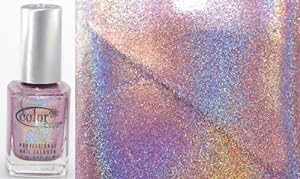

In [138]:
display.Image(color_club.loc[200571]["Image"])

In [139]:
bed_head = meta_data_df.loc[meta_data_df['ASIN'] == "B001EWF2SI"]
bed_head

,ASIN,Description,Product Name,Image,salesRank,categories,price,related,sub_cat
60398,B001EWF2SI,TIGI BedHead After the Party Smoothing Cream 3.4 Ounces,"TIGI Bed Head After the Party Smoothing Cream, 3.4 Ounce(pack of 2)",http://ecx.images-amazon.com/images/I/31oiW3t2VBL._SY300_.jpg,{'Beauty': 20241},"[[Beauty, Hair Care, Styling Products, Creams, Gels & Lotions]]",26.7,"{'also_bought': ['B003GVCU62', 'B003JP1CK0', 'B000X2DMHS', 'B003YUVMT6', 'B002AF3GG8', 'B003765EX2', 'B0072CU0VI', 'B003JP9G3U', 'B003T18TE6', 'B00FFXZZL6', 'B003T1G0XI', 'B00FFY00P6', 'B003JP5K76', 'B00BUU74JE', 'B00JMGBNYU', 'B00FFXZZV6', 'B00HESBR2Q', 'B00FFXZZG6', 'B001U2RQY0', 'B003JPBDFO', 'B00I2NZEBC', 'B00AUO9408', 'B0072CQ65M', 'B00GSE01IS', 'B00BQYWENK', 'B00DW6AFXG', 'B0039OVDJ6', 'B002L26HO8', 'B0072CWK4S', 'B001OTQXES', 'B002RS6JW6', 'B005GGMNI0', 'B0072CZ07M', 'B003N6UT86', 'B003JP1IVI', 'B00CQ7ZXX4', 'B000J40FV6', 'B002ZX56D6', 'B0072CVQGQ', 'B003S1JSWY', 'B002IT3KD0', 'B005C6H8WK', 'B0072CQW88', 'B004PADEJ0', 'B0054Y0VZG', 'B009YWC9RW', 'B001KN1HPI', 'B001PUQ3NC', 'B0045KNJIQ', 'B001F51PWG', 'B004Q8GYES', 'B0016P2JWU', 'B0025UMNU8', 'B001H7KAN2', 'B007G5C2CG', 'B003I3NEZ4', 'B0079VY1T4', 'B00J2HTFG2', 'B0072CU96O', 'B001R2IGEC', 'B0091JV52I', 'B00DPICES0', 'B00BQZ0PBC', 'B001F51PVW', 'B002ROMF0A', 'B002UQAUGG', 'B000ULFT0U', 'B006DR2BQU', 'B003TUYLAS', 'B0029ZYO24', 'B00JQQZDWE', 'B00DEOZN8I', 'B005F4BH8A', 'B00JSLU7MS', 'B003T17X3E', 'B00B9ZQ6TE', 'B00456SX54', 'B003JP0WBU', 'B000JQLNO2', 'B00GLS5DCU', 'B003URLWI4', 'B003C268NQ', 'B003JP19U8', 'B001GTK8P6', 'B00DQ69Q7S', 'B0012ZTW2E', 'B001F51PXA', 'B003T1CQDQ'], 'also_viewed': ['B003GVCU62', 'B003JP5K76', 'B003765EX2', 'B00BUU74JE', 'B000X2DMHS', 'B003JP9DMY', 'B0072CU0VI', 'B003JP1CK0', 'B00AUO9408', 'B003JP9G3U', 'B0072CQ65M', 'B00JMGBNYU', 'B003JPBDFO', 'B000E127KQ', 'B003YUVMT6', 'B00BQYWENK', 'B003JP1IVI', 'B003T1G0XI', 'B003T18TE6', 'B0072CZ07M', 'B0072CQW88', 'B001PUQ3NC', 'B00BQZ0PBC', 'B0025U8G7M', 'B004GV8C0Y', 'B003JP5COC', 'B003JP90EU', 'B005SHR4LS', 'B004RXBGSQ', 'B005SHTOYS', 'B001H7KAN2', 'B004V2923E', 'B002AF3GG8', 'B002RS6KU2', 'B00HESBR2Q', 'B001DDCW6S', 'B003JP7CSQ', 'B004GV9UVY', 'B00FFXZZL6', 'B00HTQI6NG', 'B002ROMF0A', 'B002RS6JW6', 'B003E1KYN0', 'B0041TD7A6', 'B00KH6PG4W', 'B003JP5L3E', 'B003T1CQDQ', 'B00FFXZZV6', 'B0072CTSAC', 'B0072CWK4S', 'B003JP6DCW', 'B00DPICES0', 'B0007506U2', 'B001KN1HPI', 'B0089SZQHM', 'B0050N4DRS', 'B000PB271E', 'B00FFXZZG6', 'B0025UMNU8'], 'bought_together': ['B00FFXZZV6', 'B00FFY00P6']}",Hair Care


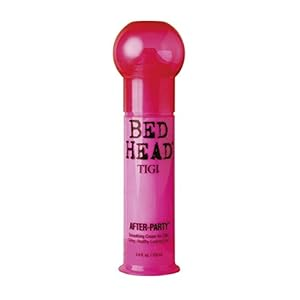

In [140]:
display.Image(bed_head.loc[60398]["Image"])

In [141]:
curious = meta_data_df.loc[meta_data_df['ASIN'] == "B000C1VT0W"]
curious

,ASIN,Description,Product Name,Image,salesRank,categories,price,related,sub_cat
13422,B000C1VT0W,"Introduced in 2004. Recommended use: casual.When&#xA0;applying&#xA0;any fragrance please consider that there are several factors which can affect the natural smell of your skin and, in turn, the way a scent smells on you.&#xA0; For instance, your mood, stress level, age, body chemistry,&#xA0;diet, and current medications may all alter the scents you wear.&#xA0;&#xA0;Similarly, factor such as dry or oily&#xA0;skin can even affect the amount of time a fragrance will last after being applied","Curious by Britney Spears for Women, Eau De Parfum Spray, 1.7 Ounce",http://ecx.images-amazon.com/images/I/412S0EUS2oL._SX300_.jpg,{'Beauty': 101730},"[[Beauty, Fragrance, Women's, Eau de Parfum]]",16.95,"{'also_bought': ['B0045U0TWA', 'B0072CY6AO', 'B00777D6LE', 'B001IQ5PZU', 'B004564IZI', 'B0045683A4', 'B004569QK0', 'B0072CVN0U', 'B0072CYE56', 'B00455ZU38', 'B0009N35D2', 'B000C1VT0M', 'B009RA8HJ0', 'B00CZE85II', 'B004R3L7X0', 'B0045FDTFE', 'B0072CQZAS', 'B007QIKPQS', 'B00BUUAFYA', 'B000C20ZKG', 'B000OP7LTY', 'B0072CY6TU', 'B0072CW0RK', 'B0072CSWEK', 'B005CYJYW4', 'B002LL4UO8', 'B0072CTKTQ', 'B00BGZDY2Y', 'B000E7UFM2', 'B003XLX046', 'B0072CTOMO', 'B008CMD85C', 'B0079VXP1E', 'B0009MYMSA', 'B0075HDNK0', 'B0072CVD3W', 'B00KDIO7IA', 'B00BY6CMFK', 'B0072CSNNU', 'B00BOWK9AY', 'B0049CV90U', 'B002LYYEKA', 'B00J5ANCD8', 'B00BUU8RM2', 'B00IPAVCL8', 'B009SZ6DPY', 'B008Y3LG4Y', 'B00FIZN98W', 'B009LUS2GY', 'B00BUUCRGO', 'B0079VTWBG', 'B0079W01HY', 'B00BUUAZ2M', 'B0072CWRAA', 'B000P20R6A', 'B000C1ZDTU', 'B0049ONNA2', 'B008148R8E', 'B0009N363G', 'B004R3OGYM', 'B00161IKD6', 'B0072CVXEG', 'B002XQ1Y86', 'B004R3OFF2', 'B000C1W38O', 'B0079W3H4I', 'B000XE87IA', 'B000C1VTIY', 'B0072CYS9I', 'B000L6IGS6', 'B0072CYJWE', 'B0072CSO7A', 'B00EU6NK66', 'B00GXHPN1U', 'B0079VYZ1S', 'B00L6XS1II', 'B004IIHGZ2'], 'also_viewed': ['B0072CY6AO', 'B004564IZI', 'B00455ZU38', 'B0009MYLD6', 'B001IQ5PZU', 'B0045683A4', 'B00777D6LE', 'B00AUJACO0', 'B003NOBLNU', 'B0072CY6TU', 'B004569QK0', 'B00CZE85II', 'B0072CVN0U', 'B00BY6CMFK', 'B0036FTETO', 'B0045U0TWA', 'B007778O48', 'B008RKD4TY', 'B000C20ZKG', '9790800967', 'B0046F2TF4', 'B00BGZDY2Y', 'B00HYBAALM', 'B00BUUDRLS', 'B009DFQE6W', 'B000OWXXSU', 'B000GI0SMQ', 'B004R3L7X0', 'B004IIFCWQ', 'B004R3LK4G', 'B000BTBJVE', 'B0051ACV92', 'B0072CYE56', 'B0072CWRAA', 'B0072CXAPG', 'B002LL4UO8', 'B0072CV6DY', 'B0072CTQV8', 'B000P20RAQ', 'B0009N35D2', 'B000OP7LTY', 'B0079VXP1E', 'B007QIKPQS', 'B0072CSXI0', 'B00HYBFM9W', 'B0079W18OE', 'B0072CSTUC', 'B00L3K3HIS', 'B0045FDTFE', 'B004A24TX8', 'B0072CQZAS', 'B0072CVD3W', 'B009SZ6DPY', 'B00IKUVFVA', 'B0072CSNNU', 'B000KE88FU', 'B0072CW5F2', 'B0045F87II', 'B0072CTOMO', 'B00BUUA1T4']}",Fragrance


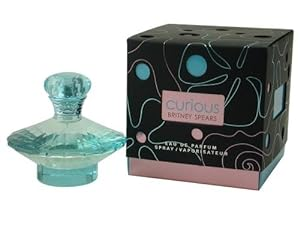

In [142]:
display.Image(curious.loc[13422]["Image"])

In [143]:
fantasy = meta_data_df.loc[meta_data_df['ASIN'] == "B000GHYSVE"]
fantasy

,ASIN,Description,Product Name,Image,salesRank,categories,price,related,sub_cat
19289,B000GHYSVE,"Launched by the design house of Britney Spears.When&#xA0;applying&#xA0;any fragrance please consider that there are several factors which can affect the natural smell of your skin and, in turn, the way a scent smells on you.&#xA0; For instance, your mood, stress level, age, body chemistry,&#xA0;diet, and current medications may all alter the scents you wear.&#xA0;&#xA0;Similarly, factor such as dry or oily&#xA0;skin can even affect the amount of time a fragrance will last after being applied",Fantasy by Britney Spears for Women - 1.7 Ounce EDP Spray,http://ecx.images-amazon.com/images/I/51MiFc%2BEZFL._SY300_.jpg,{'Beauty': 77624},"[[Beauty, Fragrance, Women's, Eau de Parfum]]",24.98,"{'also_bought': ['B0045683A4', 'B002LL4UO8', 'B000OP7LTY', 'B0072CYE56', 'B0009N0ZTO', 'B000C1W38O', 'B000HZSD02', 'B0072CR4US', 'B00777D6LE', 'B0035UZ0FW', 'B0072CYS9I', 'B003XLX2KI', 'B00CZE85II', 'B00455Y7U0', 'B001RCDSYK', 'B0009H2H0U', 'B0079VYZ1S', 'B004569QK0', 'B0079VTHJ8', 'B002LL308U', 'B000C1ZE1M', 'B0072CY7J4', 'B000VOJB50', 'B0042SNLOS', 'B00KH6WP6O', 'B0035UTVSY', 'B0072CXVH8', 'B001IQ5P8W', 'B000XE87IA', 'B0022V2PKI', 'B000C1W032', 'B004IIHGZ2', 'B003XLZ35A', 'B00BUU3RXQ', 'B003VX1KF2', 'B0020MMDNS', 'B0009N5EZO', 'B0072CX6ZU', 'B001KYS1P6', 'B0072CSXI0', 'B00A29WCA0', 'B0076K3NEC', 'B007U1SS7O', 'B0049CTLUA', 'B000C1ZFBG', 'B00A86ZN2Q', 'B003850M5M', 'B004691EYM', 'B0072CY6AO', 'B000FQ5Q9E', 'B000C21BHC', 'B005QXKVGY', 'B000C1Z6NS', 'B000TDH1SM', 'B0072CTOMO', 'B003JLKPPW', 'B0079VXP1E', 'B00BKF2QGK', 'B0072CSO7A', 'B0009N33Z2', 'B000UICT6U', 'B001IQ5PZU', 'B000XE0030', 'B0009N5EI6', 'B00J6U78PK', 'B002LKZ1JW', 'B0009N35D2', 'B00BTA6W4S', 'B003XNS850', 'B00L2ZK8EA', 'B00AEK5V5K', 'B0072CWEX0', 'B000P20R6A', 'B00DAUYQX4', 'B003S0VOJ0', 'B0009N0ZZ8', 'B00BUU8RM2', 'B0000536A3', 'B0020MMFX6', 'B000P20RAQ', 'B0072CXAPG', 'B0072CYF6Y', 'B0079VYWES', 'B0047A9ZZ0', 'B004R3LK4G', 'B007VTSVL8', 'B0015AFWH0', 'B0072CU11M', 'B0056KD6N2', 'B000AQF50Y', 'B00C7I63BI', 'B000IG3VX4', 'B008D902Q2', 'B000TDDDHA', 'B003IT6ELO', 'B00D2GT4U6', 'B0009N4K2M', 'B00A70YR5C', 'B004ILQH6I'], 'also_viewed': ['B002LL4UO8', 'B000KE88FU', 'B000P20RAQ', 'B0045683A4', 'B000ZJW6TY', 'B0072CY6AO', 'B00BY6CMFK', 'B004569QK0', 'B0042SLPZA', '9790792549', 'B0072CYE56', 'B00455Y7U0', 'B008RKD4TY', 'B000OP7LTY', 'B0079W18OE', 'B001B7I8S2', 'B00CZE85II', 'B003ZU2YVA', 'B00777D6LE', 'B004B80BWO', 'B0072CYS9I', 'B00BUUDRLS', 'B005HR0EWU', 'B0072CR4US', 'B001IQ5PZU', 'B00HYBAALM', 'B000HZSD02', 'B00KJ0HJZ0', 'B000T3JA6I', 'B00HYBFM9W', 'B00AUJACO0', 'B004EY6CKK', 'B00455ZU38', 'B004ILQH6I', 'B001288J48', 'B004IIFCWQ', 'B004R3LK4G', 'B0079VXP1E', 'B000XE87IA', 'B0072CTTCE', 'B0072CV6DY', 'B0072CSXI0', 'B00IKUVFVA', 'B0009N382U', 'B004A24TX8', 'B0072CUCX4', 'B001H3NEPC', 'B001IQ5P8W', 'B0072CQZAS', 'B0072CY7J4', 'B0009N35D2', 'B00KJ0HC2A', 'B0072CXAPG', 'B00HQH7N46', 'B0009N0ZTO', 'B0040PS4YA', 'B0009N5EZO', 'B000FQ5Q9E', 'B001RCDSYK', 'B0072CSNNU']}",Fragrance


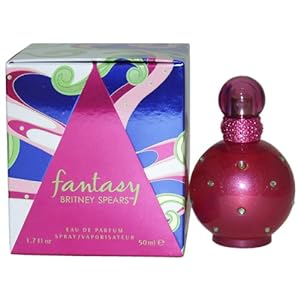

In [144]:
display.Image(fantasy.loc[19289]["Image"])

# Evaluation of Model

The following is code to take a random user, finds a product they should like based on what Amazon recommended to them in the bought together recommendations for their highest rated product. Then it uses our model to predict the user’s rating for that product.

In [145]:
#Join our review and meta data
joined_df = surprise_df.join(meta_data_df.set_index("ASIN"),on="asin",how="inner")

In [146]:
#Confirming join worked
len(joined_df) == len(surprise_df)

True

In [147]:
#Select a random reviewer 
user_ID = "AYRYR6UGT2HAG"

In [148]:
#Inspect random user's reviews
user_ID_DF = joined_df[joined_df["reviewerID"] == user_ID]
user_ID_DF

,reviewerID,asin,overall,Description,Product Name,Image,salesRank,categories,price,related,sub_cat
1705,AYRYR6UGT2HAG,B0000535RA,2,"Pore Refining Toner visibly reduces the appearance of pores. This Alpha and Beta Hydroxy formula is dermatologist tested to deliver visible results. First, it sweeps away dead surface skin and refines rough, uneven patches. Then, it penetrates deep into pores so they appear smaller and less visible. Skin is soft, smooth and refreshed.","Neutrogena Pore Refining Toner, Alpha and Beta Hydroxy Formula, 8.5 Ounce",http://ecx.images-amazon.com/images/I/317RqAhxLLL._SY300_.jpg,NaN,"[[Beauty, Skin Care, Face, Toners & Astringents]]",7.69,"{'also_bought': ['B00B2FXLSA', 'B0072CURR0', 'B005M2FB8C', 'B005OLQJGE', 'B005M31KRW', 'B00LBEJOKG', 'B001TKE47A', 'B00J7N7L08', 'B001P95NSO', 'B008NX5AGK', 'B00KN2UT8S', 'B005OLPKD2', 'B00J7ONIOK', 'B005OLPFXC', 'B00LCSLHPG', 'B005M31I4C', 'B0081E6YX4', 'B005M2GKJG', 'B00L3T1GO6', 'B00GNU9MQE', 'B003XUROHQ', 'B00J7NVLTA', 'B00AHU877Q', 'B0087GOBAY', 'B00L7BXBVQ', 'B006RFZ66K', 'B00BI0LWMQ', 'B00J2H9FGW', 'B00J7PL9F4', 'B0088W7OLU', 'B005M2GFVO', 'B005M34XOY', 'B005M2O1WE', 'B005OLQA36', 'B009YX97D0', 'B001OMI974', 'B00AW691D4', 'B003YCN7B0', 'B0009F3O22', 'B00BOWO92S', 'B0047PTKOQ', 'B003XUROEY', 'B005M2EIRM', 'B0048IHITQ', 'B00B2G03JY', 'B00JJDIH9A', 'B003N21THK', 'B0088W8MI4', 'B00J7OCYXG', 'B0088W8RKC', 'B00027DMI8', 'B00JIRRTYG', 'B005NI80RY', 'B005OLPIXE', 'B005M32MV0', 'B004AI53A0', 'B005M32J3Q', 'B00HNSSPDG', 'B00ILN5QC0', 'B0081NLR8M', 'B00J7MGXU8', 'B00008CMOQ', 'B0009RFB76', 'B000WHYATS', 'B00J7OD2W8', 'B0000536Y7', 'B0067H6MC0', 'B002UUT39M', 'B00D1XV4WG', 'B00HRQRL5W', 'B004D2DR0Q', 'B005MZDSMK', 'B000052YM8', 'B00DMCVTIA', 'B002XGWQFG', 'B00IWNPTD0', 'B00112BT88', 'B0012J135O', 'B00563CM5M', 'B00GYF65TK', 'B00BZ1QN2C', 'B00J7ONPO8', 'B00JA6D0HA', 'B00387F42G', 'B000EPA4FW', 'B00772AKMM', 'B002JDUMFO', 'B005M2NSI2', 'B00005360J', 'B006RFZ98K', 'B005M32OX6', 'B005M31X88', 'B00J7PLTH2', 'B005M31C2K', 'B000RH1TRE', 'B0009ENKLS', 'B000052YM3', 'B003RF82RI'], 'also_viewed': ['B00B2FXLSA', 'B00EZWSNGM', 'B005M2FB8C', 'B0072CURR0', 'B00BI0LWMQ', 'B005M31I4C', 'B005OLPKD2', 'B001FQPPWQ', 'B001TKE47A', 'B008MZBHW0', 'B00BUIQB36', 'B00J7PL9F4', 'B00I7J5JWK', 'B005M34XOY', 'B00GTNPEBC', 'B005M31KRW', 'B00DGCEUMI', 'B00GNU9MQE', 'B00J7OD2W8', 'B00D1XV4WG', 'B004CR3D4W', 'B00CGBU9O8', 'B00BDTGRLI', 'B00A4667CU', 'B005OLPHJY', 'B00J2H9FGW', 'B001PV4WZ2', 'B003CQZ1A8', 'B00CLBY2VY', 'B000052YOU', 'B000ALBLMU', 'B00J7ONPO8', 'B0088W7OHE', 'B002B8KP4A', 'B0073GNP0Q', 'B005M2EIRM', 'B00J7N7L08', 'B002K8MK0I', 'B001F51TR2', 'B00563CM5M', 'B00KN2UT8S', 'B00AHU877Q', 'B005M31X88', 'B005M31C2K', 'B0087GOBAY', 'B00F1D56HI', 'B0019TM2E8', 'B00GMP9BH0', 'B00HYHBPMO', 'B0072CXA4W', 'B00CW4X72U', 'B0047PTKOQ', 'B009YX97D0', 'B00LCSLHPG', 'B00AQRLSH6', 'B008D6QBAG', 'B005OLPS0W'], 'bought_together': ['B00B2FXLSA']}",Skin Care
49424,AYRYR6UGT2HAG,B001ABLKK2,5,"Cure Natural Aqua Gel is the #1 best selling exfoliator in Japan, selling 1 bottle every 12 seconds. Cure's unique and gentle formula allows for it to be used on people with even the most sensitive skin. Cure's status as a cult hit and Japanese beauty product legend stems from the simple fact that Cure does what it promises: exfoliates gently and effectively, without any harsh chemicals or alcohol.",Cure Natural Aqua Gel 250ml - Best selling exfoliator in Japan!,http://ecx.images-amazon.com/images/I/31vU0Gb9N6L._SY300_.jpg,{'Beauty': 57},"[[Beauty, Skin Care, Face, Exfoliators & Scrubs, Exfoliators]]",28.00,"{'also_bought': ['B004LRO7DO', 'B000FQUGXA', 'B00BSNBO9O', 'B004KPYWM8', '1568364067', 'B0007601RO', 'B00KFZ0E1K', 'B001CC1VV2', 'B00E8LUBZ6', 'B008ULYYJY', 'B00IZUSNRO', 'B000FQS1YQ', 'B001UE60E0', 'B001CPM03C', 'B007RUW2RA', 'B00BS3Q372', 'B0036MDUEM', 'B007HEP0R0', 'B00J3LEEJK', 'B00260T94K', 'B004FKPWWC', 'B000FQ4ZX2', 'B00J48RC5K', 'B00809ERAM', 'B002KCCEGO', 'B000TCIGBO', 'B00GBI590Q', 'B00HH07ZEU', 'B008ULYXR2', 'B00C1

In [149]:
#checking the items the users have reviewed; looking at asin with 5 review: Cure Natural Aqua Gel
#in the related column, we see products that are purchased with Cure Natural Aqual Gel
#pulling out the asin of the related product--we assume user should also like this product
#will check our system's predicted rating 

Biore SARASARA UV Aqua Rich Waterly Essence Sunscreen 50g SPF50+ PA+++ for Face and Body.SPF50+ PA+++ sunscreen for face and body.It is Water-base Wash off with regular cleanser.Fresh fruit aroma


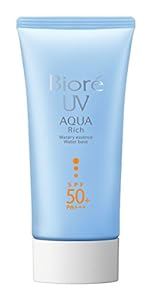

In [150]:
#Find Amazon's bought together recommendation ASIN for user's top rated item
bt_asin = user_ID_DF[user_ID_DF["overall"] == (user_ID_DF["overall"].max())]["related"].values[0]["bought_together"][0]
#We expect that this ASIN should recieve a high predicted rating from our sytem
from IPython import display
print(joined_df[joined_df["asin"]==bt_asin]["Description"].values[0])
display.Image(joined_df[joined_df["asin"]==bt_asin]["Image"].values[0])

In [151]:
#User our model to predict a rating given this product and user combination
best_model.predict(uid=user_ID,iid=bt_asin)

Prediction(uid='AYRYR6UGT2HAG', iid='B004LRO7DO', r_ui=None, est=4.261800862764359, details={'was_impossible': False})

In [152]:
#estimated rating of 4.26 for this product for this user

# Final Model Evaluation

The final recommendation model employing Singular Value Decomposition (SVD) achieved a Root Mean Square Error (RMSE) of 1.0820. This indicates that, on average, our predicted review scores for Amazon buyers deviated by 1.0820 points from the true values. Notably, this score represents a significant improvement of more than half a point compared to our baseline model on a review scale of 1-5.

Beyond the enhanced predictive accuracy, the model incorporates additional features that contribute to the personalization of post-purchase marketing emails:

No Repeat Products: The model intelligently avoids recommending items that the buyer has already purchased. This approach enhances product discoverability by presenting a diverse set of suggestions.

Prioritization of Best Matches: Whether recommending through the entire product catalog or within a specific subcategory, the model consistently delivers a curated selection of the top predicted reviews for a given buyer. This ensures that recommendations align closely with individual preferences.

Subcategory Filtering: The model allows for fine-tuned filtering of beauty products based on six subcategories. This capability refines the search process, enabling buyers to explore recommendations within more specific and tailored product groupings.

Image Retrieval: The model goes beyond textual information by converting product URLs to images. In marketing emails, recommended titles and descriptions are accompanied by visually appealing images, enhancing the overall presentation and making the recommendations more engaging for the buyers.

# Limitations and Next Steps

While our model excels in minimizing the RMSE for predicted reviews, it does face certain limitations. Firstly, our dataset exhibits a bias towards higher ratings, with nearly 60% of all reviews receiving a perfect score of 5 points. This skewness influences our predicted values, particularly impacting lower-rated items. To assess whether these high ratings are reflective of actual Amazon buyer behavior or are specific to our dataset, further investigation is recommended.

Secondly, the model is not well-equipped to handle indiscriminate reviewers who consistently rate all products the same. This limitation hinders the accurate capture of their preferences. To address this issue, we propose conducting a separate survey post-purchase to gather more insights into the preferences of these reviewers. This information could be leveraged to enhance our model in future iterations.

Thirdly, our model encounters challenges related to the cold start problem, requiring prior user reviews to offer recommendations. To overcome this, we suggest incorporating a content-based approach that considers product characteristics to make initial recommendations in the absence of user history.

Finally, observations indicate that the dataset occasionally misclassifies products into subcategories (e.g., haircare, skincare), leading to inaccuracies in subcategory predictions. To mitigate this, we recommend implementing a standardized classification process for subcategories when adding new products to the marketplace. This approach ensures more accurate predictions from the subcategory predictor.

# Conclusion

The Amazon marketing team can seamlessly integrate our recommendation tools to swiftly enhance the personalization of user recommendations. This implementation promises to elevate user engagement and drive increased purchases. Furthermore, our model lends itself well to strategic marketing initiatives, allowing the team to tailor recommendations based on seasonal trends. For instance, personalized Skin Care recommendations can be emphasized during the winter or dry seasons, while Fragrance recommendations can be highlighted around occasions like Valentine's Day, optimizing the marketing approach for specific user needs and preferences.




